In [118]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [119]:
key_length = 32
noise = 0
dim_multiplier = 100
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [120]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

def uniform_initializer2(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5)
    
def binary_key_initializer(key_length):
    return (torch.rand(key_length,1) > 0.5).float()

In [121]:
#secret keys
#ascii 0-94
secret_key = binary_key_initializer(key_length)
print(secret_key.shape)

torch.Size([32, 1])


In [131]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
    
    def apply_wnoise_realistic(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        encoded = torch.zeros((self.out_dim, X.shape[1])).to(self.device)
        for i in range(X.shape[1]):
            encoded[:,i] = (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X[:,i].view(-1,1)) > self.epsilon).float().view(-1)
        return encoded
    


In [132]:
#One hot net    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon):
        super(One_hot_net, self).__init__()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        self.tail = nn.Linear(feature_len, n_class)

    def forward(self, X):
        X = self.f_encoder.apply_wnoise(X, noise)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return X.transpose(1,0)
    
    def decrypt(self, X):
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return (X.transpose(1,0) > 0.5).float()

In [133]:
parameters = {
    'in_dim': key_length,
    'n_class': key_length,
    'f_encoder': simple_encoder_wthreshold(key_length*dim_multiplier, key_length, 0),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': dim_multiplier,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}

In [134]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon']).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.005, momentum=0.5)


In [135]:
#create training and testing set
def make_data(size):
    data = (torch.rand(key_length,size) > 0.5).float().to(device)
    return [data, torch.logical_xor(data, torch.squeeze(secret_key.to(device)).repeat(size,1).T).float()]

n_epochs = 50
n_batch = 2000
batch_size_train = 50
batch_size_test = 50

train_loader = [make_data(batch_size_train) for i in range(n_batch)]
test_loader = [make_data(batch_size_test) for i in range(n_batch)]

print(len(train_loader), train_loader[0][0].shape)

2000 torch.Size([32, 50])


In [136]:
train_losses = []
test_losses = []

In [137]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    train_loss = 0
    for batch_idx, (label_data, data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()(output, label_data)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(float(train_loss))
    print('Epoch: {}, Train set: Avg. loss: {:.6f}'.format(epoch,
        train_loss))
    return model, optimizer
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for (label_data, data) in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += nn.MSELoss()(output, label_data).item()
    test_loss /= len(test_loader)
    test_losses.append(float(test_loss))
    #print(output[:,0]-data[:,0])
    print('Test set: Avg. loss: {:.6f}'.format(
        test_loss))
    return test_loss

In [138]:
model_name = "crypto_net1"
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)

Epoch: 1, Train set: Avg. loss: 0.037821
Test set: Avg. loss: 0.022398
Epoch: 2, Train set: Avg. loss: 0.020164
Test set: Avg. loss: 0.018366
Epoch: 3, Train set: Avg. loss: 0.016611
Test set: Avg. loss: 0.015365
Epoch: 4, Train set: Avg. loss: 0.013944
Test set: Avg. loss: 0.013079
Epoch: 5, Train set: Avg. loss: 0.011903
Test set: Avg. loss: 0.011304
Epoch: 6, Train set: Avg. loss: 0.010313
Test set: Avg. loss: 0.009905
Epoch: 7, Train set: Avg. loss: 0.009056
Test set: Avg. loss: 0.008787
Epoch: 8, Train set: Avg. loss: 0.008051
Test set: Avg. loss: 0.007884
Epoch: 9, Train set: Avg. loss: 0.007236
Test set: Avg. loss: 0.007144
Epoch: 10, Train set: Avg. loss: 0.006570
Test set: Avg. loss: 0.006536
Epoch: 11, Train set: Avg. loss: 0.006021
Test set: Avg. loss: 0.006030
Epoch: 12, Train set: Avg. loss: 0.005565
Test set: Avg. loss: 0.005607
Epoch: 13, Train set: Avg. loss: 0.005183
Test set: Avg. loss: 0.005250
Epoch: 14, Train set: Avg. loss: 0.004861
Test set: Avg. loss: 0.004948
E

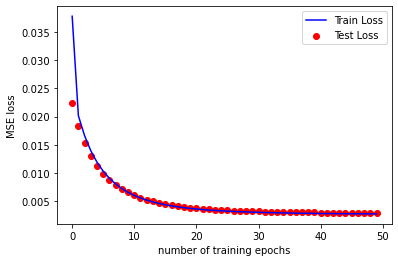

In [139]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.scatter(range(len(test_losses)), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training epochs')
plt.ylabel('MSE loss')
plt.show()

In [165]:
#Testing Encoded sentence
#message = "It is time to test the model on real-world data"#. We must choose a sentence and an image. We choose the following sentence from Wikipedia: Anthony Edward \"Tony\" Stark is a character portrayed by Robert Downey Jr. in the MCU film franchise and for the image, we use the same Tony Stark’s image from the beginning of the article. The following code is used to embedding and extracting the message:"
message = (torch.rand(key_length,1) > 0.5).float()
#message = 
print(message.T)

tensor([[0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.]])


In [166]:
def encrypt(message, model, secret_key, n = noise):
    secret_message = torch.logical_xor(message.to(device), secret_key.to(device)).float()
    return model.f_encoder.apply_wnoise_realistic(secret_message, n)

In [167]:
encrypted_message = encrypt(message, model1, secret_key, n = 0.8)

In [168]:
print(encrypted_message, encrypted_message.shape)

tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]], device='cuda:0') torch.Size([3200, 1])


In [169]:
# plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)

In [170]:
decrypted_m = model1.decrypt(encrypted_message)
print(decrypted_m.T)
def decryption_accuracy(message, decrypted_message):
    count = 0
    message = message.to(device)
    decrypted_message = decrypted_message.to(device)
    for i in range(len(message)):
        if message[i] == decrypted_message[i]:
            count+=1
    return count/len(message) * 100
print("decryption accuracy is {}%".format(round(decryption_accuracy(message, decrypted_m), 2)))

tensor([[0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.]],
       device='cuda:0')
decryption accuracy is 100.0%


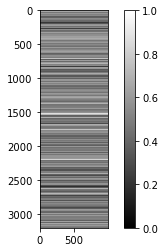

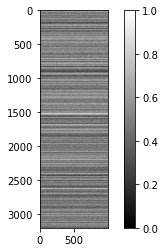

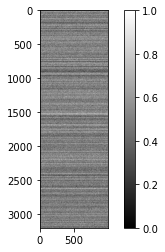

In [177]:
#Visualize variance caused by noise
def visualize(message, model, secret_key, n = noise):
    encrypted_message = torch.zeros(key_length*dim_multiplier,1000)
    for i in range(1000):
        encrypted_message[:,i] = torch.squeeze(encrypt(message, model, secret_key, n = n))
    #print(encrypted_message)
    #print(torch.sum(encrypted_message[:,1]-encrypted_message[:,0]))
    plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

visualize(message, model1, secret_key, n = 0)
visualize(message, model1, secret_key, n = 0.8)
visualize(message, model1, secret_key, n = 2)

In [202]:
#message_index = [(ord(c)-32) for c in message]
#print(message_index)
#secret_message = secret_key[:, message_index]#.to(device)
#output = model1(secret_message)
#print(output[:,0]-secret_message[:,0])

[41, 84, 0, 73, 83, 0, 84, 73, 77, 69, 0, 84, 79, 0, 84, 69, 83, 84, 0, 84, 72, 69, 0, 77, 79, 68, 69, 76, 0, 79, 78, 0, 82, 69, 65, 76, 13, 87, 79, 82, 76, 68, 0, 68, 65, 84, 65]
tensor([-5.3554e-01, -6.1449e-04,  1.4492e-01, -5.5073e-01,  1.0839e+00,
        -1.1452e+00,  2.3126e-01, -1.5485e-01, -1.0052e+00,  9.9301e-01],
       device='cuda:0', grad_fn=<SubBackward0>)
